## Quantum Convolutional Neural Networks

Here, we will implement a Quantum Convolutional Neural Network , a quantum machine learning model, introduced by [Henderson et al.](https://arxiv.org/abs/1904.04767)

#### Classical Convolution

The convolutional neural network (CNN) is a standard model in classical machine learning which is particularly suitable for processing images. The model is based on the idea of a convolution layer where, instead of processing the full input data with a global function, a local convolution is applied.

If the input is an image, small local regions are sequentially processed with the same kernel. The results obtained for each region are usually associated to different channels of a single output pixel. The union of all the output pixels produces a new image-like object, which can be further processed by additional layers

### Quantum Convolution

Same idea can be used in quantum variational circuits.



1.   A small region of the input image $2 \times 2$ square (in our examples) is embedded into a quantum circuit. We achieve this with the help of parameterized rotations applied to the qubits intialized in the ground state.
2.   A quantum computation, associated to a unitary $U$, is performed on the system. The unitary could be generated by a variational quantum circuit, or by a random circuit.

3. The quantum system is finally measured, obtaining a list of classical expectation values. The measurement results could also be classicaly post-processed.

4. Analogously to a classical convolutional layer, each expectation value is mapped to a different channel of a single output pixel

5. Iterating the same procedure over different regions, we can scan the entire image, producing an output object which will be structured as multi-channel image.

6. The quantum convolution can be followed by further quantum layers or by classical layers.


## Importing basic libraries

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Setting the main hyper-parameters

In [3]:
n_epochs = 40     # number of epochs to run
n_layers = 1      # number of random layers
n_train = 50      # size of training dataset
n_test = 30       # size of test dataset



SAVE_PATH = 'qcnn/'   # where to save
PREPROCESS = True    # if false, skip quantum processing and load data from saved path

np.random.seed(135)
tf.random.set_seed(135)

### Load the dataset
We will work with the MNIST dataset, which is already available in tensorflow.

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

We will only be working with a small subset of the entire problem

In [5]:
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]

# for the test data
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

## Normalizing the data

In [6]:
train_images = train_images / 255
test_images = test_images / 255

#### Adding an extra dimension for the convolutional channels

In [7]:
train_images = np.array(train_images[..., tf.newaxis], requires_grad = False)

test_images = np.array(test_images[..., tf.newaxis], requires_grad = False)


### Quantum Circuit as a convolution kernel

We follow the scheme  described below. We initialize the Pennylane ```default.qubit``` device, simulating a system of 4 Qubits. 
The associated ```qnode```  represents the quantum circuit consisiting of:



1.   an embedding layer of local $R_y$ rotations (with angles scaled by a factor of $\pi$)
2.   a random circuit of ```n_layers```
3. a final measurement in the computational basis, estimating $4$ expectation values.



In [8]:
dev = qml.device('default.qubit', wires=4)

# now the random circuit

rand_params = np.random.uniform(high=2*np.pi, size = (n_layers,4))

@qml.qnode(dev)

def circuit(phi):
  # encoding of 4 classical input
  for j in range(4):
    qml.RY(np.pi *phi[j], wires = j)

  # random circuit

  RandomLayers(rand_params, wires = list(range(4)))


  # Measurement
  return [qml.expval(qml.PauliZ(j)) for j in range(4)]

### The convolutional Scheme



1.   the image is divided into squares of $2 \times 2$ pixels
2.   each square is processed by the quantum circuit
3. the $4$ expectation values are mapped into $4$ different channels of a single output pixel



In [9]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Quantum Preprocessing

Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder SAVE_PATH. Once saved, they can be directly loaded by setting PREPROCESS = False, otherwise the quantum convolution is evaluated at each run of the code.

In [11]:

if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save( "q_train_images.npy", q_train_images)
    np.save( "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load( "q_train_images.npy")
q_test_images = np.load( "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


### Visualize

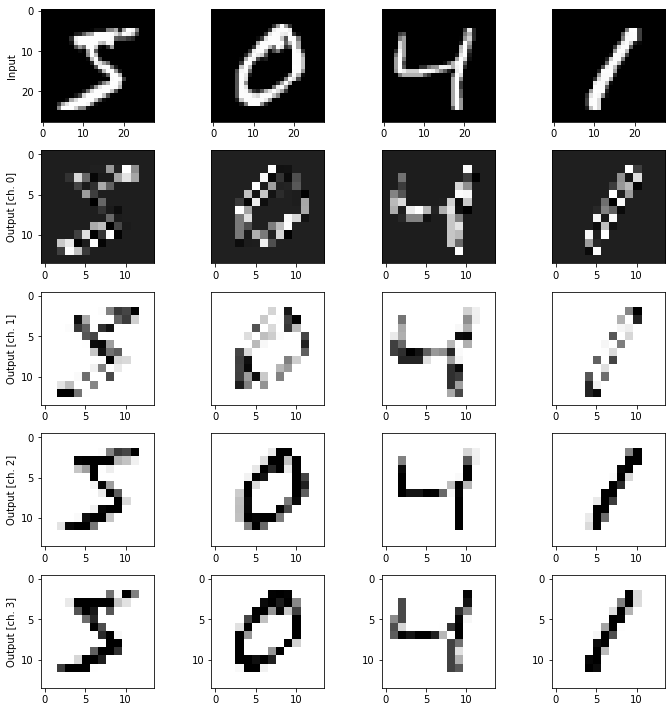

In [12]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the 
4
 output channels generated by the quantum convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local distortion introduced by the quantum kernel. On the other hand the global shape of the image is preserved, as expected for a convolution layer.



### Hybrid quantum-classical model
After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the 
10
 different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.

The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.

In [13]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training

We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution

In [14]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/40
13/13 - 1s - loss: 3.0104 - accuracy: 0.1200 - val_loss: 2.5016 - val_accuracy: 0.2000 - 1s/epoch - 83ms/step
Epoch 2/40
13/13 - 0s - loss: 2.0123 - accuracy: 0.2800 - val_loss: 2.0673 - val_accuracy: 0.3333 - 69ms/epoch - 5ms/step
Epoch 3/40
13/13 - 0s - loss: 1.6072 - accuracy: 0.4800 - val_loss: 1.7850 - val_accuracy: 0.4333 - 65ms/epoch - 5ms/step
Epoch 4/40
13/13 - 0s - loss: 1.2395 - accuracy: 0.6800 - val_loss: 1.7656 - val_accuracy: 0.4667 - 72ms/epoch - 6ms/step
Epoch 5/40
13/13 - 0s - loss: 1.0249 - accuracy: 0.8200 - val_loss: 1.6069 - val_accuracy: 0.5000 - 68ms/epoch - 5ms/step
Epoch 6/40
13/13 - 0s - loss: 0.8238 - accuracy: 0.8800 - val_loss: 1.5258 - val_accuracy: 0.5667 - 72ms/epoch - 6ms/step
Epoch 7/40
13/13 - 0s - loss: 0.7094 - accuracy: 0.9600 - val_loss: 1.5157 - val_accuracy: 0.5000 - 60ms/epoch - 5ms/step
Epoch 8/40
13/13 - 0s - loss: 0.5844 - accuracy: 0.9000 - val_loss: 1.4053 - val_accuracy: 0.6000 - 71ms/epoch - 5ms/step
Epoch 9/40
13/13 - 0s - l

In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).

In [15]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/40
13/13 - 1s - loss: 2.3347 - accuracy: 0.2000 - val_loss: 2.1675 - val_accuracy: 0.2333 - 556ms/epoch - 43ms/step
Epoch 2/40
13/13 - 0s - loss: 1.9302 - accuracy: 0.4200 - val_loss: 2.0252 - val_accuracy: 0.2333 - 58ms/epoch - 4ms/step
Epoch 3/40
13/13 - 0s - loss: 1.6462 - accuracy: 0.6400 - val_loss: 1.8608 - val_accuracy: 0.5333 - 68ms/epoch - 5ms/step
Epoch 4/40
13/13 - 0s - loss: 1.4028 - accuracy: 0.7800 - val_loss: 1.7376 - val_accuracy: 0.6333 - 66ms/epoch - 5ms/step
Epoch 5/40
13/13 - 0s - loss: 1.2109 - accuracy: 0.8400 - val_loss: 1.6222 - val_accuracy: 0.6667 - 65ms/epoch - 5ms/step
Epoch 6/40
13/13 - 0s - loss: 1.0509 - accuracy: 0.8800 - val_loss: 1.5271 - val_accuracy: 0.6333 - 60ms/epoch - 5ms/step
Epoch 7/40
13/13 - 0s - loss: 0.9227 - accuracy: 0.9200 - val_loss: 1.4636 - val_accuracy: 0.6667 - 107ms/epoch - 8ms/step
Epoch 8/40
13/13 - 0s - loss: 0.8070 - accuracy: 0.9400 - val_loss: 1.3931 - val_accuracy: 0.7333 - 67ms/epoch - 5ms/step
Epoch 9/40
13/13 - 0s

## Results

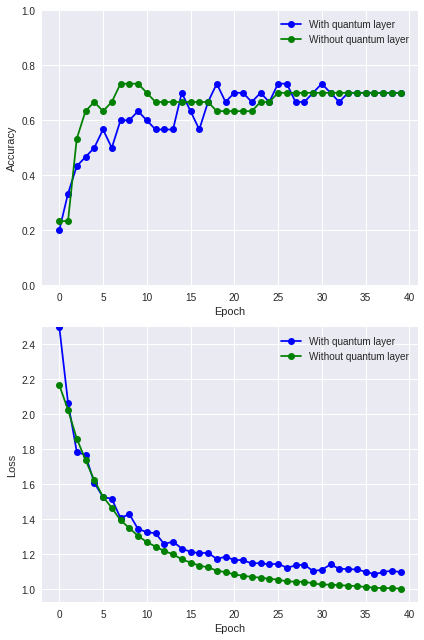

In [16]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()